In [1]:
%pylab inline
import pandas as pd
import datetime
import seaborn as sns
import warnings
from pyABS import PyABS as pyabs

Populating the interactive namespace from numpy and matplotlib


In [2]:
warnings.filterwarnings('ignore')

In [3]:
rates = pd.read_csv('weekly_rates_approx.csv' , parse_dates=True, index_col='date')

In [4]:
rates.head(5)

libor  3_yr_auto_AAA  3_yr_credit_card_AAA  3_yr_student_loan_AAA  \
date                                                                            
2000-01-07    658             29                    16                     16   
2000-01-14    661             29                    16                     16   
2000-01-21    664             29                    16                     16   
2000-01-28    663             29                    16                     16   
2000-02-04    678             30                    16                     16   

            3_yr_helc_AAA  1_yr_helc_AAA  1_yr_auto_AAA  1_yr_credit_card_AAA  \
date                                                                            
2000-01-07             97             41              9                    10   
2000-01-14             97             41              9                    10   
2000-01-21             97             41              9                    10   
2000-01-28             97             41              9                    10   
2000-02-04             99             43              9                    10   

            1_yr_student_loan_AAA  
date                               
2000-01-07                     11  
2000-01-14                     11  
2000-01-21                     11  
2000-01-28                     11  
2000-02-04                     11

In [5]:
to_graph = rates.filter(like='3_yr').columns.tolist()

In [6]:
to_graph.append('libor')

In [7]:
to_graph

['3_yr_auto_AAA',
 '3_yr_credit_card_AAA',
 '3_yr_student_loan_AAA',
 '3_yr_helc_AAA',
 'libor']

# Some historical milestones to determine train, test, split

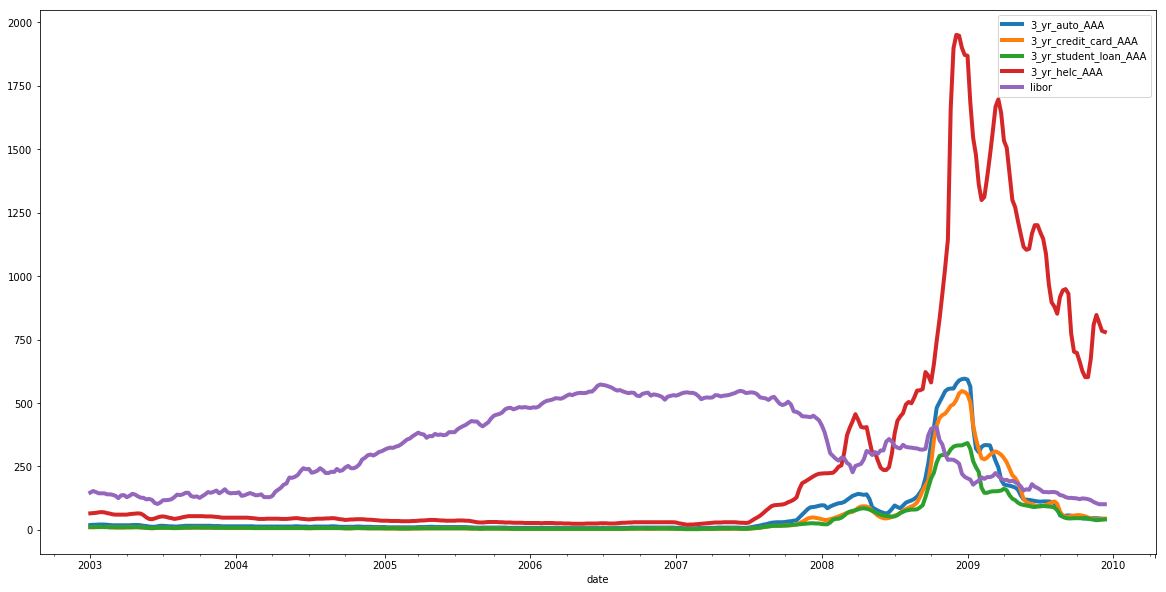

In [8]:
rates['20030101':'20091231'][to_graph].plot(figsize=(20,10), linewidth=4)
plt.legend()
plt.show()

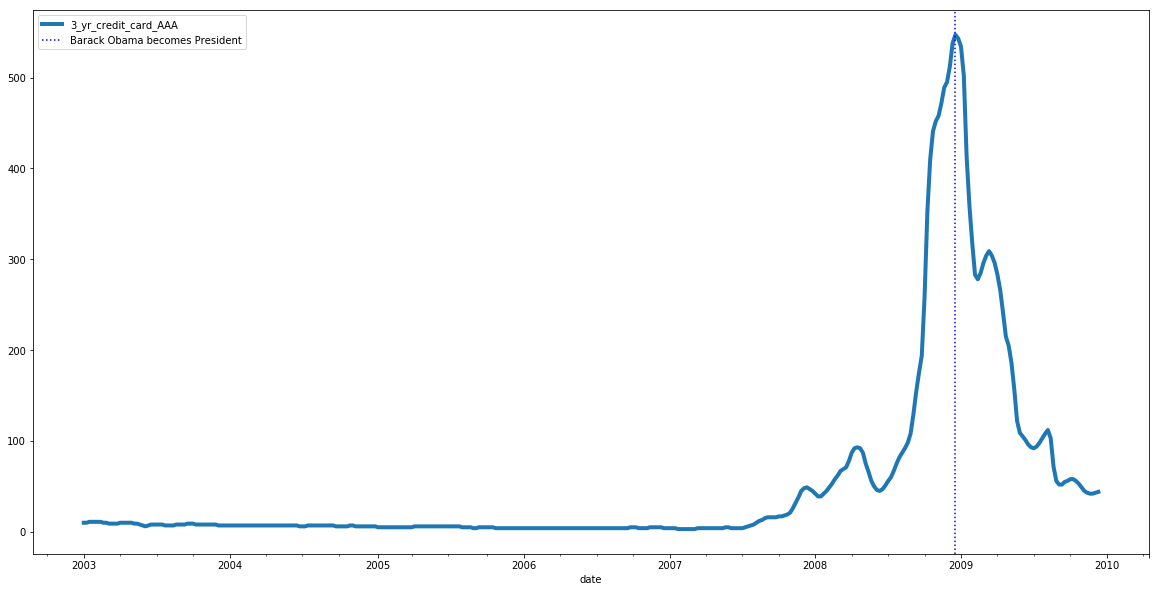

In [9]:
rates['20030101':'20091231']['3_yr_credit_card_AAA'].plot(figsize=(20,10), linewidth=4)
xcoords = ['20081215']
colors = ['b']
legend = ['Barack Obama becomes President']
for xc, c, l in zip(xcoords, colors, legend):
    plt.axvline(x=xc, label=l, c=c, linestyle='dotted')

plt.legend()
plt.show()

# Zoom in in the period of the crisis

In [10]:
xcoords = ['20080314', '20080517','20080915', '20081003', '20081215', '20090218']
colors = ['k','g','b','orange','r', 'black']
legend = ['Bears Stearns bailout',
          'Town of Vallejo, CA, goes bankrupt',
          'Lehman Brothers bankruptcy',
          'AIG, CITI, Goldman Sachs, etc. rescued with 105Bn USD',
          'Barack Obama becomes President',
          'Federal Reserve releases TALF Master Loan and Security Agreement']

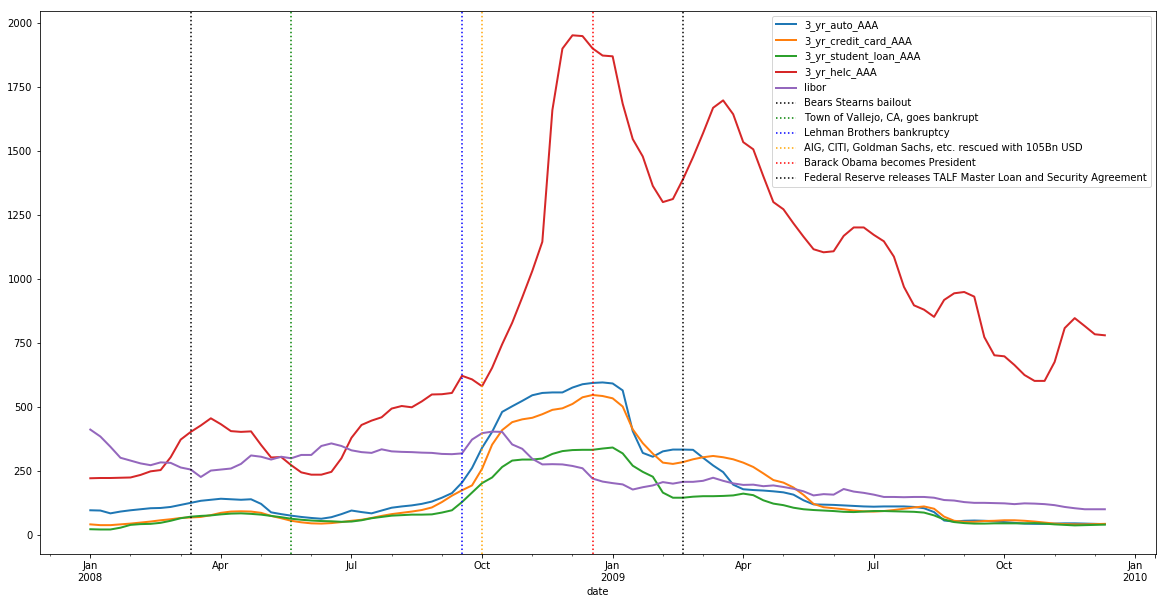

In [11]:
rates[to_graph]['20080101':'20091231'].plot(figsize=(20,10), linewidth=2)
xcoords = xcoords
colors = colors
legend = legend
for xc, c, l in zip(xcoords, colors, legend):
    plt.axvline(x=xc, label=l, c=c, linestyle='dotted')

plt.legend()
plt.show()

# I will split the time series at the time of the announcement of the TALF Master Loan and Securty Agreement

In [12]:
df_weekly_train = rates[:'20090218']
df_weekly_test = rates['20090218':]

<Figure size 1440x576 with 0 Axes>

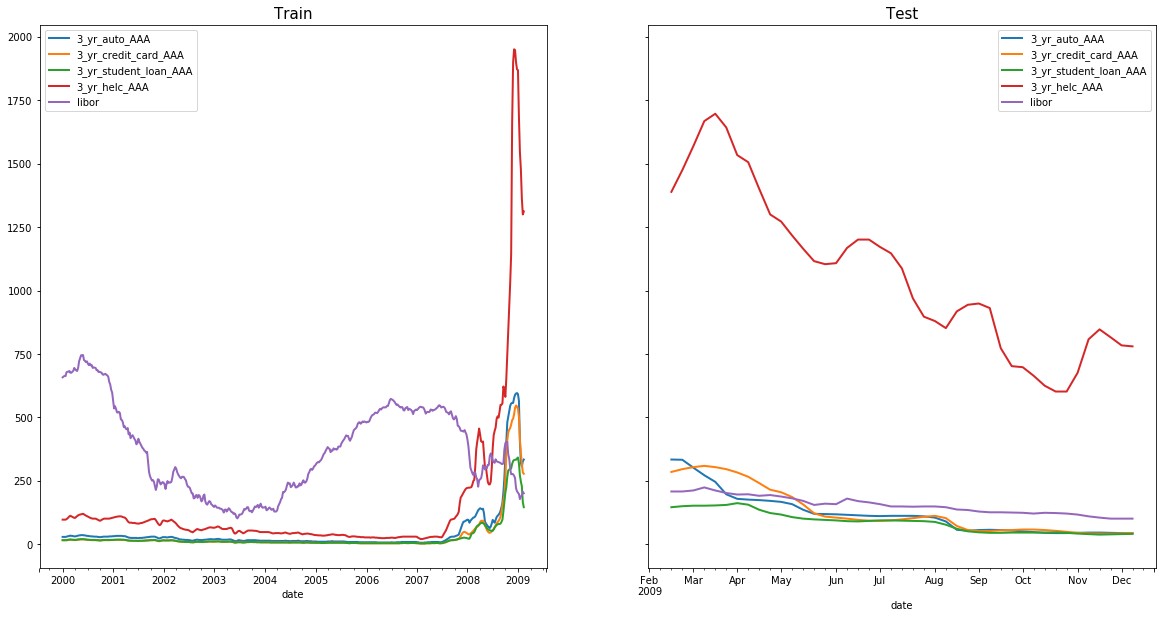

In [13]:
f = plt.figure(figsize=(20,8))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Train', fontsize=15)
ax2.set_title('Test', fontsize=15)
df_weekly_train[to_graph].plot(figsize=(20,10), linewidth=2, ax=ax1)
df_weekly_test[to_graph].plot(figsize=(20,10), linewidth=2, ax=ax2)

## For simplicity's sake, I will only simulate the 3 years rates + LIBOR. The one year rates will be the 3 year rate minus the average historical spreads up to 2009-02-18; and the two year rate will be halfway that spread

In [14]:
auto_spread = int((df_weekly_train['3_yr_auto_AAA'] - df_weekly_train['1_yr_auto_AAA']).mean())
student_spread = int((df_weekly_train['3_yr_student_loan_AAA'] - df_weekly_train['1_yr_student_loan_AAA']).mean())
helc_spread = int((df_weekly_train['3_yr_helc_AAA'] - df_weekly_train['1_yr_helc_AAA']).mean())
credit_card_spread = int((df_weekly_train['3_yr_credit_card_AAA'] - df_weekly_train['1_yr_credit_card_AAA']).mean())

In [15]:
(auto_spread, student_spread, helc_spread, credit_card_spread)

(12, 2, 42, 4)

In [16]:
spreads = {'3_yr_auto_AAA': 0,
           '3_yr_student_loan_AAA': 0,
           '3_yr_helc_AAA':0,
           '3_yr_credit_card_AAA':0,
           '2_yr_auto_AAA': auto_spread*0.5,
           '2_yr_student_loan_AAA': student_spread*0.5,
           '2_yr_helc_AAA':helc_spread*0.5,
           '2_yr_credit_card_AAA':credit_card_spread*0.5,
           '1_yr_auto_AAA': auto_spread,
           '1_yr_student_loan_AAA': student_spread,
           '1_yr_helc_AAA':helc_spread,
           '1_yr_credit_card_AAA':credit_card_spread}

In [17]:
df_weekly_train = df_weekly_train[['libor', '3_yr_auto_AAA', '3_yr_student_loan_AAA', '3_yr_helc_AAA', '3_yr_credit_card_AAA']]

# Mean Reversion and Autocorrelation

Mean reversion is the assumption that an asset's price will tend to move to some long term avergae. This might happen with inerest rates, commodities, currencies, etc. Deviations from the average levels are expected to revert to the average.

Autocorrelation or serial correlation, is the correlation of a signal with itself as a function of a time lag. It is often used in signal processing for analyzing functions or series of values, such as time domain signals. 

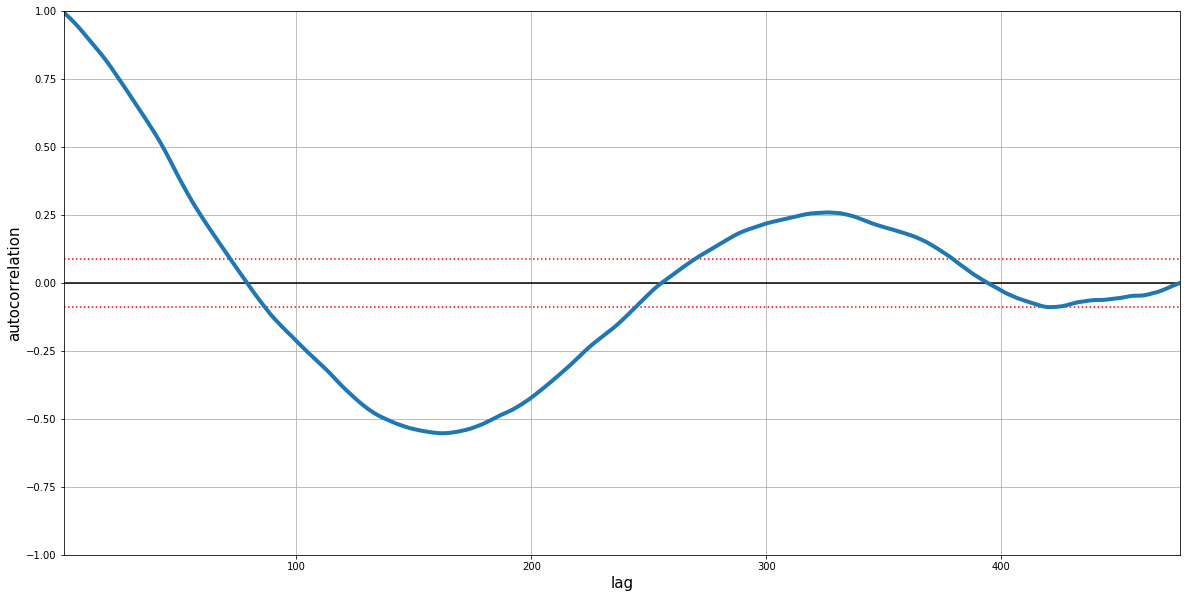

In [18]:
#LIBOR
plt.figure(figsize=(20,10))
df_libor, lags_libor, ax_libor = pyabs.autocorrelation_and_significance(df_weekly_train['libor'], linewidth=4)

In [19]:
df_libor.head()

autocorrelation  lag
0         0.994355    1
1         0.987326    2
2         0.979424    3
3         0.971131    4
4         0.962208    5

In [20]:
lags_libor

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 19

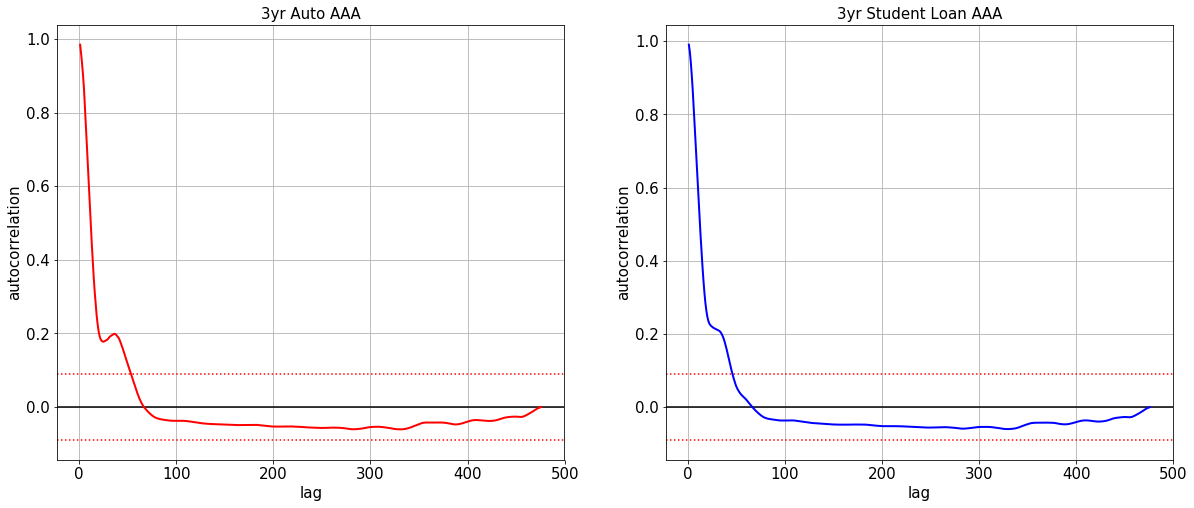

In [21]:
f = plt.figure(figsize=(20,8))
ax0 = f.add_subplot(121)
ax1 = f.add_subplot(122)

ax0.set_title('3yr Auto AAA', fontsize=15)
ax1.set_title('3yr Student Loan AAA', fontsize=15)

df_auto, lags_auto, ax_auto = pyabs.autocorrelation_and_significance(df_weekly_train['3_yr_auto_AAA'], ax=ax0, color='r', linewidth=2)
df_student, lags_student, ax_student = pyabs.autocorrelation_and_significance(df_weekly_train['3_yr_student_loan_AAA'], ax=ax1, color='blue', linewidth=2) #row=0, col=0

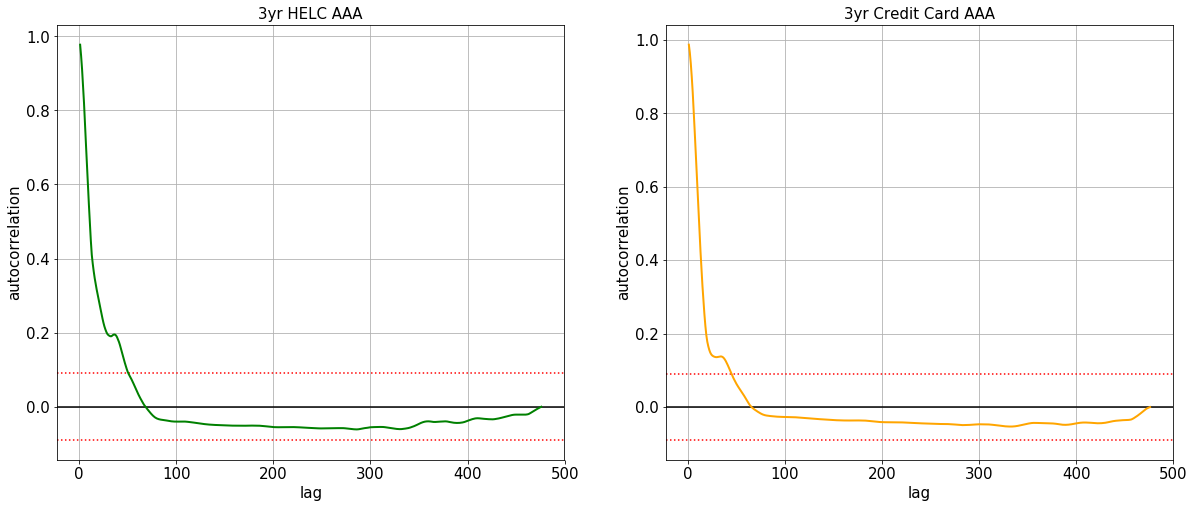

In [22]:
f = plt.figure(figsize=(20,8))
ax0 = f.add_subplot(121)
ax1 = f.add_subplot(122)
ax0.set_title('3yr HELC AAA', fontsize=15)
ax1.set_title('3yr Credit Card AAA', fontsize=15)
df_helc, lags_helc, ax_helc = pyabs.autocorrelation_and_significance(df_weekly_train['3_yr_helc_AAA'], ax=ax0, color='g', linewidth=2)
df_credit, lags_credit, ax_credit = pyabs.autocorrelation_and_significance(df_weekly_train['3_yr_credit_card_AAA'], ax=ax1, color='orange', linewidth=2)

# Order of AR Model

By inspecting the lags_libor list, we can see that for LIBOR rates, there are several lags that have statistically significant positive and negative autocorrelation. All of them are good candidates to model future rates. 

Although we could use all valid lags, for all assets, we will probably be over fitting our models. A solution is to fit N models, and measure the Akaike Information  Criterion and/or the Bayesian Information Criterion for each model, and see which number of parameters gives us the lowest BIC or AIC.

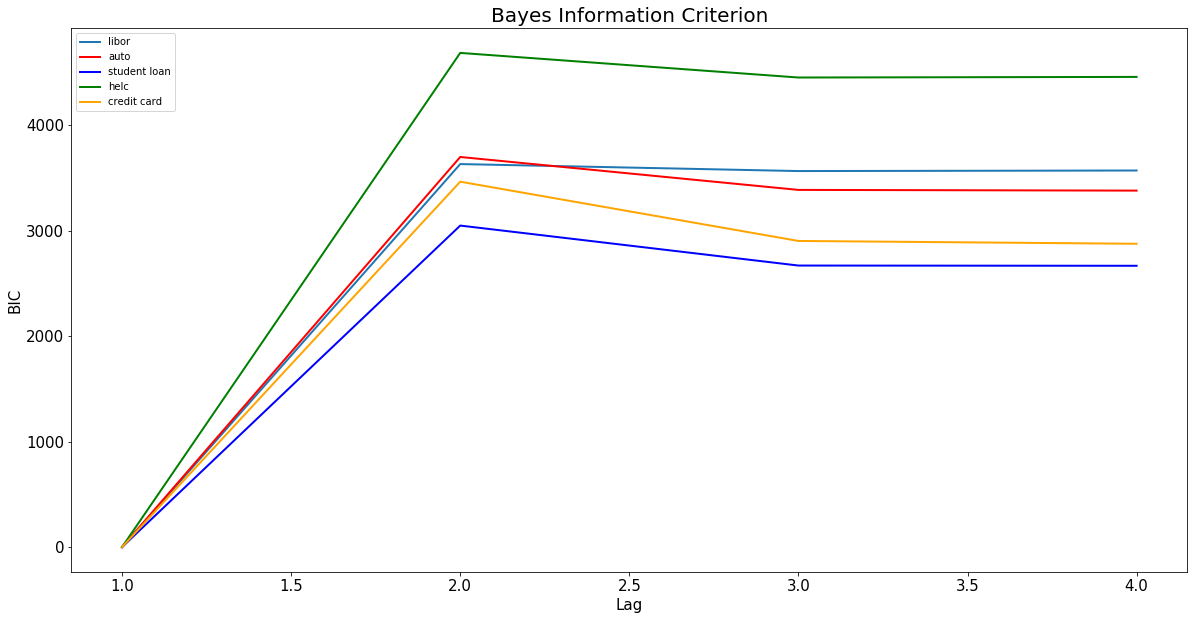

In [23]:
criteria ='BIC'
f = plt.figure(figsize=(20,10))
pyabs.optimal_params_ar_model(df_weekly_train['libor'], lags_libor, test_criteria=criteria, linewidth=2, label='libor')
pyabs.optimal_params_ar_model(df_weekly_train['3_yr_auto_AAA'], lags_auto, test_criteria=criteria, linewidth=2,color='r', label='auto')
pyabs.optimal_params_ar_model(df_weekly_train['3_yr_student_loan_AAA'], lags_student, test_criteria=criteria, linewidth=2,color='b', label='student loan')
pyabs.optimal_params_ar_model(df_weekly_train['3_yr_helc_AAA'], lags_helc, test_criteria=criteria, linewidth=2,color='g', label='helc')
pyabs.optimal_params_ar_model(df_weekly_train['3_yr_credit_card_AAA'], lags_credit, test_criteria=criteria, linewidth=2,color='orange', label='credit card')

I will simulate rates using AR1 models for all assets. According to the AIC or BIC, models higher than AR1 might contribute to overfitting our model.

In [24]:
ar_params_dict = pyabs.ar_param_dictionary(df_weekly_train, 1)

In [25]:
ar_params_dict[0]

{'name': 'libor', 'summary': <class 'statsmodels.iolib.summary.Summary'>
 """
                               ARMA Model Results                              
 Dep. Variable:                  libor   No. Observations:                  476
 Model:                     ARMA(1, 0)   Log Likelihood               -1806.964
 Method:                       css-mle   S.D. of innovations             10.707
 Date:                Mon, 22 Apr 2019   AIC                           3619.927
 Time:                        20:57:55   BIC                           3632.423
 Sample:                    01-07-2000   HQIC                          3624.841
                          - 02-13-2009                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------------
 const         416.6711    185.863      2.242      0.025      52.387     780.955
 ar.L1.libor     0.9987      0.002    6

# Correlations

The MC simulation needs to generate simulated rates that keep the properties of their historical correlations. For simplicity, I will calculate the correlation among the different asset classes at the same maturity, and assume that the correlation of, for example, the 3 years AUTO ABS AAA spread and the 1 year AUTO AAA ABS spread is 100% (which is close to the behavior in real life most of the time). I will also generate a date_index that will contain all the future dates of our analysis and the potential longest maturity of the simulated bonds we will buy.

In [26]:
sims = 100000
longest_tenor_yrs = 3
purchase_weeks = 5
date_ix = pd.date_range(start=df_weekly_train.index[-1], 
                        periods= (purchase_weeks + 1) + longest_tenor_yrs * 52, freq='7D')

In [27]:
all_sims, assets_sims = pyabs.simulate_several_sets_correlated_rates(df_weekly_train, sims, date_ix, ar_params_dict)

100%|██████████| 100000/100000 [03:15<00:00, 510.53it/s]


# Below are indications for TALF leverage and for type of assets to acquire, as well as my estimated probabilities of availability of those assets at different tenors. 

This was the FEDs leverage program to provide incentives to purchase ABS, giving more leverage to the assets they determined were key, for example, ABS backed by credit card receivables @1-2 yrs. You could have committed 5% of the price of the bond, the FED provided 95%, non recourse, at LIBOR + 100bps

In [28]:
pyabs.f_risk_capital

{'auto_AAA': {1: 0.1, 2: 0.11, 3: 0.12},
 'student_loan_AAA': {1: 0.08, 2: 0.09, 3: 0.1},
 'helc_AAA': {1: 0.12, 2: 0.13, 3: 0.14},
 'credit_card_AAA': {1: 0.05, 2: 0.05, 3: 0.06}}

Probability of issuance is a function of the market share of the elegible bonds outstanding in the market as 
of late 2008

In [29]:
pyabs.p_issuance

{'auto_AAA': 0.2,
 'student_loan_AAA': 0.2,
 'helc_AAA': 0.3,
 'credit_card_AAA': 0.3}

We assume that issuers favor longer tenors compared to shorter ternors

In [30]:
pyabs.p_term

{1: 0.2, 2: 0.3, 3: 0.5}

# Probabilities of AAA assets being downgraded or defaulting in the holding period.

To estimate this, I created a function that defines a transition matrix based on generic historical transitions probabilities for AAA rates ABS in one year, excluding mortgages. 
This 1 year transition matrix can be used to model transitions from any initial state ("AAA", "AA", "A", "BBB", "BB", "B", "CCC") to any other state plus "D" using a one state Markov process. 
We can estimates the probabilities of transition over a given number of years by adding the 1-year transition matrix to a recursive function as a function of time.

In [31]:
pyabs.estimate_1yr_transition('AAA')

'AA'

In [32]:
pyabs.estimate_transition_vector('B', 5)

['B', 'D']

So, with the rates at the time of the TALF announcment, what would have been the annual returns in a no loss scenario, if we had invested invested in a typical "AAA" 3 year credit card securitization that week?

In [33]:
df_weekly_train.tail()

libor  3_yr_auto_AAA  3_yr_student_loan_AAA  3_yr_helc_AAA  \
date                                                                     
2009-01-16    178            406                    271           1546   
2009-01-23    187            321                    247           1478   
2009-01-30    194            306                    228           1363   
2009-02-06    207            327                    166           1300   
2009-02-13    201            334                    146           1312   

            3_yr_credit_card_AAA  
date                              
2009-01-16                   413  
2009-01-23                   359  
2009-01-30                   318  
2009-02-06                   283  
2009-02-13                   278

### Sample annual returns, no defaults

$${Annual Return}_{(Asset, Term)} = \frac{((LIBOR + Spread)*fRiskCapital) + ((Spread - Haircut)*(1-fRiskCapital))}{fRiskCapital}$$

In [34]:
def expected_talf_return(libor, spread, haircut, f_risk_capital):
    ar = (((libor + spread)*f_risk_capital) + (spread - haircut)*(1-f_risk_capital))/f_risk_capital
    return ar

In [35]:
expected_talf_return(0.0201, 0.0278, 0.01, 0.06)

0.32676666666666665

In [36]:
purch = pyabs.simulate_purchase_per_sim_rate_scenario(purchase_weeks=purchase_weeks, 
                                                      sims=sims, 
                                                      rates_sim_dict=all_sims, 
                                                      spreads_dict=spreads, 
                                                      date_index=date_ix)

100%|██████████| 100000/100000 [04:28<00:00, 372.21it/s]


In [37]:
purch[1]

asset  purchase_week purchase_date maturity_date  term  \
0          2_yr_auto_AAA              1    2009-02-20    2011-02-18     2   
1  3_yr_student_loan_AAA              2    2009-02-27    2012-02-24     3   
2          3_yr_auto_AAA              3    2009-03-06    2012-03-02     3   
3          3_yr_helc_AAA              4    2009-03-13    2012-03-09     3   
4  3_yr_student_loan_AAA              5    2009-03-20    2012-03-16     3   

   f_risk_capital  risk_capital    fed_loan  total_purchase       libor  \
0            0.11          30.0  242.727273      272.727273  155.505012   
1            0.10          20.0  180.000000      200.000000  394.016972   
2            0.12          20.0  146.666667      166.666667  442.332836   
3            0.14          20.0  122.857143      142.857143  462.419017   
4            0.10          10.0   90.000000      100.000000  506.156940   

   spread_over_libor  exp_annual_r final_rating  
0         275.921631      0.185479          AAA  
1         187.742154      0.137144          AAA  
2         515.305064      0.400321          AAA  
3        1987.066642      1.404147           AA  
4         181.393143      0.142009          AAA

# Now that I have a good amount of scenarios (contained in the purch dictionary of dataframes), I can answer questions to help me decide if commiting capital to the TALF program is a good idea

In [38]:
#solution = pd.concat(purch, axis=0, copy='False', ignore_index=True)
solution = pd.concat(purch, axis=0, copy='False')

In [39]:
solution.reset_index(inplace=True)
solution.drop(['level_1'], axis=1, inplace=True)
solution.rename({'level_0': 'simulation'}, axis=1, inplace=True)

In [40]:
solution.head(5)

simulation                  asset  purchase_week purchase_date  \
0           0          2_yr_helc_AAA              1    2009-02-20   
1           0  1_yr_student_loan_AAA              2    2009-02-27   
2           0          2_yr_helc_AAA              3    2009-03-06   
3           0   2_yr_credit_card_AAA              4    2009-03-13   
4           0          2_yr_helc_AAA              5    2009-03-20   

  maturity_date  term  f_risk_capital  risk_capital    fed_loan  \
0    2011-02-18     2            0.13          30.0  200.769231   
1    2010-02-26     1            0.08          20.0  230.000000   
2    2011-03-04     2            0.13          20.0  133.846154   
3    2011-03-11     2            0.05          20.0  380.000000   
4    2011-03-18     2            0.13          10.0   66.923077   

   total_purchase       libor  spread_over_libor  exp_annual_r final_rating  
0      230.769231  280.656972         574.627459      0.403164          AAA  
1      250.000000  374.080272         107.962178      0.057361          AAA  
2      153.846154  493.387057         284.248517      0.201068          AAA  
3      400.000000  477.995178         156.302191      0.170404          AAA  
4       76.923077  457.172088         149.663873      0.093920          AAA

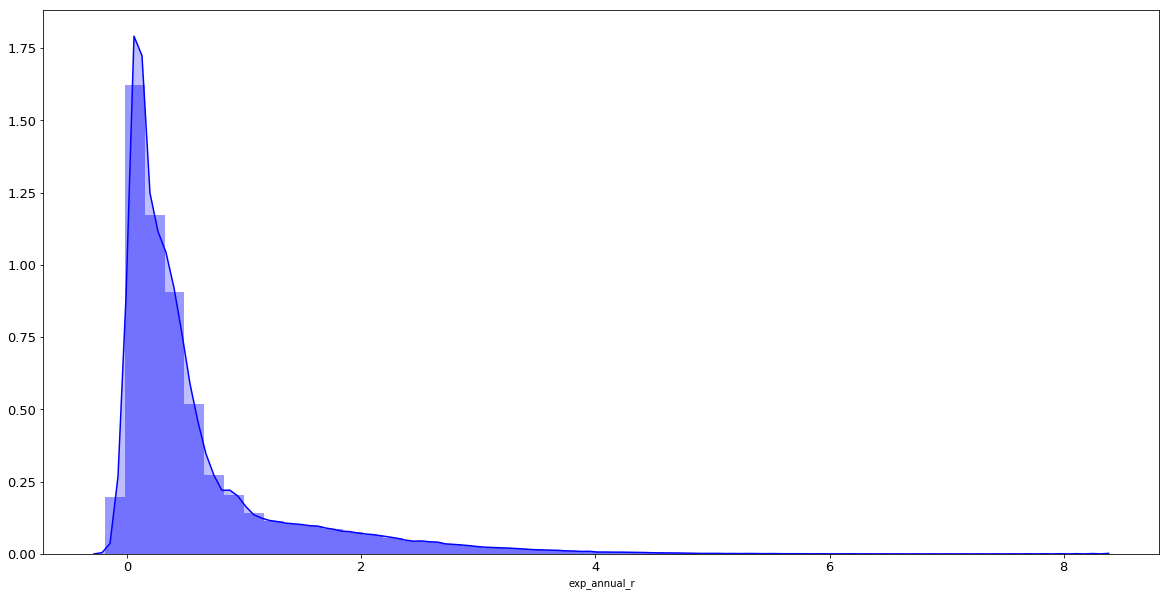

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(solution['exp_annual_r'],hist=True, color="b", kde_kws={"shade": True})

In [42]:
solution.describe(percentiles = [0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

simulation  purchase_week          term  f_risk_capital  \
count  500000.000000  500000.000000  500000.00000   500000.000000   
mean    49999.500000       3.000000       2.30131        0.097535   
std     28867.542326       1.414215       0.78052        0.031971   
min         0.000000       1.000000       1.00000        0.050000   
1%        999.990000       1.000000       1.00000        0.050000   
5%       4999.950000       1.000000       1.00000        0.050000   
10%      9999.900000       1.000000       1.00000        0.050000   
25%     24999.750000       2.000000       2.00000        0.060000   
50%     49999.500000       3.000000       3.00000        0.100000   
75%     74999.250000       4.000000       3.00000        0.120000   
90%     89999.100000       5.000000       3.00000        0.140000   
95%     94999.050000       5.000000       3.00000        0.140000   
99%     98999.010000       5.000000       3.00000        0.140000   
max     99999.000000       5.000000       3.00000        0.140000   

        risk_capital       fed_loan  total_purchase          libor  \
count  500000.000000  500000.000000   500000.000000  500000.000000   
mean       20.000000     214.339632      234.339632     239.218029   
std         6.324562     118.146471      121.885102     156.088645   
min        10.000000      61.428571       71.428571       0.004747   
1%         10.000000      61.428571       71.428571       6.002528   
5%         10.000000      73.333333       83.333333      28.694204   
10%        10.000000      90.000000      100.000000      54.355043   
25%        20.000000     133.846154      153.846154     120.483985   
50%        20.000000     180.000000      200.000000     215.574096   
75%        20.000000     303.333333      333.333333     330.574061   
90%        30.000000     380.000000      400.000000     451.083062   
95%        30.000000     470.000000      500.000000     530.692428   
99%        30.000000     570.000000      600.000000     695.336104   
max        30.000000     570.000000      600.000000    1314.916331   

       spread_over_libor   exp_annual_r  
count      500000.000000  500000.000000  
mean          729.064966       0.576642  
std          1023.313618       0.758518  
min           -41.984413      -0.189819  
1%             15.494713      -0.066703  
5%             67.435845      -0.000592  
10%           103.462095       0.038657  
25%           170.351673       0.114661  
50%           310.828554       0.311956  
75%           682.576420       0.660218  
90%          2174.658168       1.597708  
95%          3052.094667       2.256344  
99%          4743.200779       3.548305  
max         10862.514479       8.290513

In [43]:
len(solution[solution['exp_annual_r']<0])/(sims*purchase_weeks)

0.050568

In [44]:
solution['final_rating'].value_counts(normalize='True')

AAA    0.885012
AA     0.100520
A      0.011328
BBB    0.001478
BB     0.000790
B      0.000488
CCC    0.000250
D      0.000134
Name: final_rating, dtype: float64

In [45]:
strategy_df = solution[solution['exp_annual_r']>0.05]

In [46]:
len(strategy_df)/(sims*purchase_weeks)

0.88086

In [47]:
len(strategy_df[strategy_df['final_rating'] !='AAA'])/(sims*purchase_weeks)

0.101238

In [48]:
strategy_df['exp_annual_r'].median()

0.36951324267180685

In [49]:
strategy_df[strategy_df['final_rating'] == 'D'].head(20)

simulation                  asset  purchase_week purchase_date  \
13656         2731   3_yr_credit_card_AAA              2    2009-02-27   
17800         3560          3_yr_auto_AAA              1    2009-02-20   
22609         4521          2_yr_auto_AAA              5    2009-03-20   
23746         4749          2_yr_auto_AAA              2    2009-02-27   
29792         5958  3_yr_student_loan_AAA              3    2009-03-06   
47674         9534          3_yr_helc_AAA              5    2009-03-20   
59662        11932   3_yr_credit_card_AAA              3    2009-03-06   
78832        15766   3_yr_credit_card_AAA              3    2009-03-06   
83986        16797          3_yr_helc_AAA              2    2009-02-27   
107376       21475          2_yr_auto_AAA              2    2009-02-27   
109586       21917          3_yr_auto_AAA              2    2009-02-27   
111486       22297          3_yr_helc_AAA              2    2009-02-27   
112277       22455   3_yr_credit_card_AAA              3    2009-03-06   
118735       23747          2_yr_helc_AAA              1    2009-02-20   
120100       24020          3_yr_auto_AAA              1    2009-02-20   
123211       24642          3_yr_auto_AAA              2    2009-02-27   
138361       27672   3_yr_credit_card_AAA              2    2009-02-27   
141327       28265   2_yr_credit_card_AAA              3    2009-03-06   
145162       29032          3_yr_auto_AAA              3    2009-03-06   
148520       29704          3_yr_auto_AAA              1    2009-02-20   

       maturity_date  term  f_risk_capital  risk_capital    fed_loan  \
13656     2012-02-24     3            0.06          20.0  313.333333   
17800     2012-02-17     3            0.12          30.0  220.000000   
22609     2011-03-18     2            0.11          10.0   80.909091   
23746     2011-02-25     2            0.11          20.0  161.818182   
29792     2012-03-02     3            0.10          20.0  180.000000   
47674     2012-03-16     3            0.14          10.0   61.428571   
59662     2012-03-02     3            0.06          20.0  313.333333   
78832     2012-03-02     3            0.06          20.0  313.333333   
83986     2012-02-24     3            0.14          20.0  122.857143   
107376    2011-02-25     2            0.11          20.0  161.818182   
109586    2012-02-24     3            0.12          20.0  146.666667   
111486    2012-02-24     3            0.14          20.0  122.857143   
112277    2012-03-02     3            0.06          20.0  313.333333   
118735    2011-02-18     2            0.13          30.0  200.769231   
120100    2012-02-17     3            0.12          30.0  220.000000   
123211    2012-02-24     3            0.12          20.0  146.666667   
138361    2012-02-24     3            0.06          20.0  313.333333   
141327    2011-03-04     2            0.05          20.0  380.000000   
145162    2012-03-02     3            0.12          20.0  146.666667   
148520    2012-02-17     3            0.12          30.0  220.000000   

        total_purchase       libor  spread_over_libor  exp_annual_r  \
13656       333.333333  102.944751         326.835848      0.398354   
17800       250.000000  213.625186         556.469620      0.411754   
22609        90.909091   84.103016         209.102276      0.117594   
23746       181.818182  410.628256         459.564211      0.377939   
29792       200.000000  271.363301         298.522953      0.235659   
47674        71.428571  171.759199         948.958479      0.633575   
59662       333.333333  339.501266         398.960563      0.542218   
78832       333.333333   32.844833         423.783654      0.552924   
83986       142.857143  366.254608        1445.065874      1.007387   
107376      181.818182   65.368833         289.166456      0.188506   
109586      166.666667  248.203935         239.122136      0.150756   
111486      142.857143   25.059227         766.057845      0.488262   
112277      333.3

In [50]:
strategy_df[strategy_df['final_rating'] == 'D']['total_purchase'].sum(), strategy_df.total_purchase.sum()

(12535.192585192586, 104240310.93628594)

In [51]:
(strategy_df[strategy_df['final_rating'] == 'D']['total_purchase'].sum()/strategy_df.total_purchase.sum())*10000

1.2025283187091012

In [52]:
strategy_df['risk_capital'].sum()/strategy_df['total_purchase'].sum()

0.0853633294075537

In [53]:
sum(strategy_df['term']*strategy_df['total_purchase'])/sum(strategy_df['total_purchase'])

2.2422016470713686

In [54]:
def test_sim_and_real(asset, assets_sims, sims, df_test, cap=10, percentiles = [25,50,75]):
    cols = assets_sims[asset].columns
    # plot the percentile bands
    for i in range(len(percentiles)):
        assets_sims[asset]['p'+ str(percentiles[i])] = assets_sims[asset][cols].apply(lambda x: np.percentile(x, percentiles[i]), axis=1)
        assets_sims[asset]['p'+ str(percentiles[i])][:cap].plot(color='k', linestyle='dotted', linewidth=3)
    # plot the simulation paths
    for i in range(min(5000,sims)):
        assets_sims[asset][i][:cap].plot(color='blue', alpha=0.01)
    # plot the real rates
    df_weekly_test[asset][:cap].plot(figsize=(20,10), color='orange', linewidth=4)


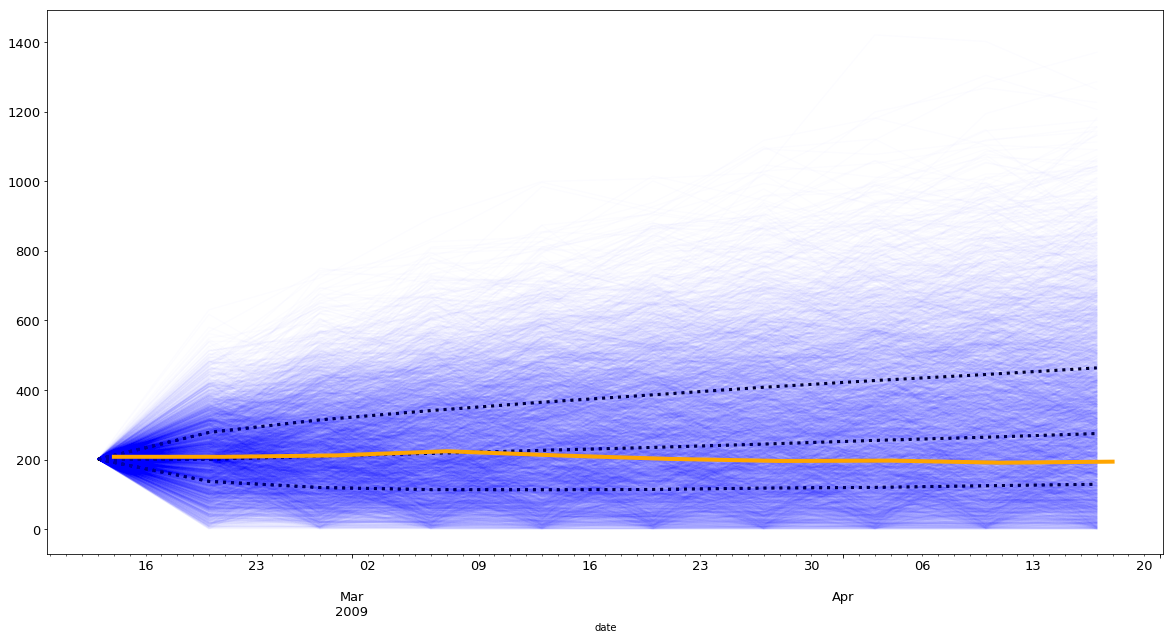

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
test_sim_and_real('libor', assets_sims, sims, df_weekly_test)

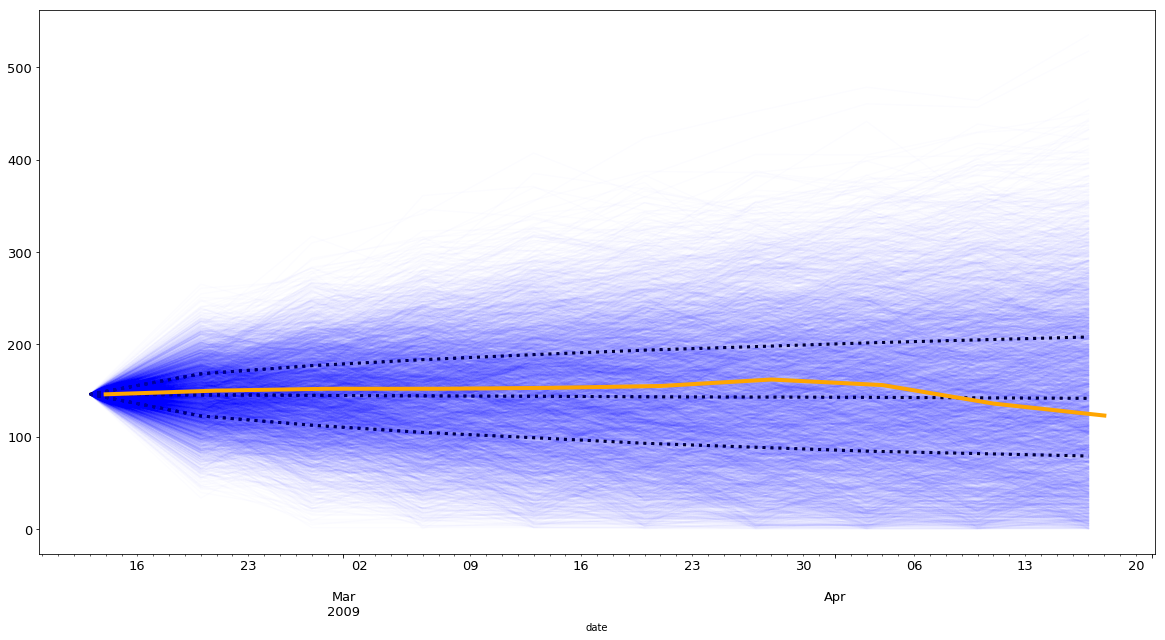

In [56]:
fig, ax = plt.subplots(figsize=(20,10))
test_sim_and_real('3_yr_student_loan_AAA', assets_sims, sims, df_weekly_test)